<a href="https://colab.research.google.com/github/caspervanengelenburg/CV-sessions-IAP-course/blob/main/2023/Interactive_Arch_Q3_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CV for IAP (Session 2)

---
Abbreviations:
- **CV**: Computer vision </br>
- **IAP**: Interactive architecture prototypes
---

In this assignment you will get familiar with **using traditional CV techniques for the purpose of structural reasoning from images**; such as contour finding algorithms, perspective warping, and geometric object handling.

Always a good idea to check the python version!

In [246]:
!python --version

Python 3.9.16


## Import IA-CV library

First install the package `requests` in order to create a library from an (online and open available) python script.

In [247]:
import sys
'requests' in sys.modules

True

If the above cell outputs `False`, install the request package! (code below)

In [ ]:
# !pip install requests

Please run the following to download the python library that we made:

In [257]:
import requests

def url2libary(url):
    
    #get url
    r = requests.get(url)

    # make sure your filename is the same as how you want to import 
    with open('iacv.py', 'w') as f:
        f.write(r.text)

# If you are using GitHub, make sure you get the "Raw" version of the code
url = 'https://raw.githubusercontent.com/caspervanengelenburg/CV-sessions-IAP-course/main/2023/iacv_lib.py'

url2libary(url)

We can now import our own library:

In [260]:
import iacv

Use `inspect.getmembers` to check all methods within a library. We do so for our own library `iacv`. (There is no need to understand the inner workings of the `inspect.getmembers` function.)

In [261]:
from inspect import getmembers, isfunction
function_list = getmembers(iacv, isfunction)

# getmembers outputs a list of functions of the library that is inputted.
# loop over the list and print every function sequentially.
for function in function_list:
  print(function[0])


blur
border2color
concat_images_horizontally
contours2polygons
dilate
edge
erode
findcnts
get_angle_from_line
get_angles
get_hole_polygons_from_contours
get_largest_edge_from_polygon
getshape
imresize
imshow
pix2metric
pixpermetric
plot_polygon
plot_robot_grab
rgb2gray
simplify_by_angle
simplify_polygons
warp


You see already that there are many functions that you can use. Some will **not** be used in this assignment (as they are solely used in previous year's assignment).

*Note*: the source code for the functions can be found using the navigation panel on the left. Click on `Files` and open (=double-click) `ia-cv-library.py`. The script, including all the functions is nicely plotted as sidebar on the right. You can even modify the functions in the script (the original one in our repository will not be modified by your changes in the local environment). **Note that if you disconnect from the server, your changes are lost (!!), so if you want to keep your changes, make sure to copy it to your drive or somewhere on your local device.**

## Drive mount and load image

Let's mount the drive and load an image.

In [262]:
import cv2
import os
from google.colab import drive

mount_path = '/content/drive'
if not os.path.ismount(mount_path):  # check if already mounted
  drive.mount(mount_path)

Now, we can load an image from the drive. Make sure the file exists (e.g. spaces should be added, capital sensitive). 

Shape of the image: (746, 654, 3)


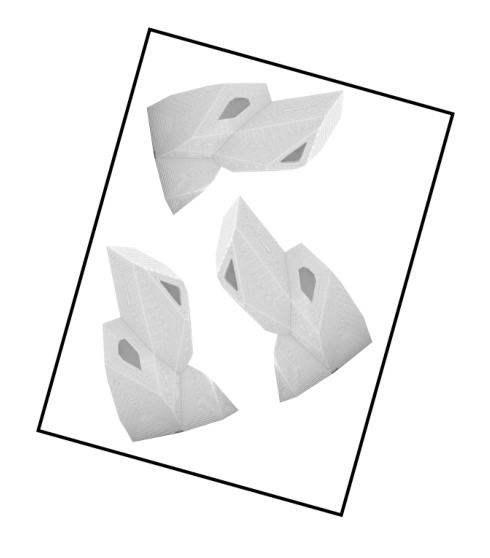

In [264]:
#read image using cv2.imread (note: these might differ from your folder structure and filename)
image = cv2.imread(r"/content/drive/My Drive/PhD/Interactive architecture/3compounds_trivial.png")

#shows the image
iacv.imshow(image)
print(f"Shape of the image: {image.shape}") 

# `print` is a to-python-native function and can be used in many ways. 
# (For example by putting an 'f' in front of the string you can make it print variables or part of them within a sentence.)

## Reference frame alignment

In the image above, the frame indicates the pick region. (Clearly this is hugely simplified w.r.t. a real-case scenario.) The frame, the rectangular boundary around the 3 components, is slightly rotated w.r.t. the image frame. Ideally, we would have an image showing the frame 1) axis-aligned, and 2) such that the frame is exactly the size of the image. The latter is important because we generally know the size of the frame; from which subsequently the object properties can be estimated if the object's geometry is known. 

This challenge - here refered to as perspective warping - will be solved in 4 consecutive steps:

- *Edge detection* to detect the edges in the image; this makes it easier for to find the frame in the next step.
- *Frame detection* which detects the frame contour from the image. 
- *Perspective warp* to rotate and scale the image.
- *Black pixel removal* to make sure the frame is not visible in the final image.

The frame are detected using a **contour finding technique**; a function native to the Open-CV libary: `cv2.findContours()`. Usually, some pre-processing is necessary to make this function find the appropriate contours. For pre-processing, we use similar tools as last week, namely edge detection. 

Shape of the image: (746, 654)


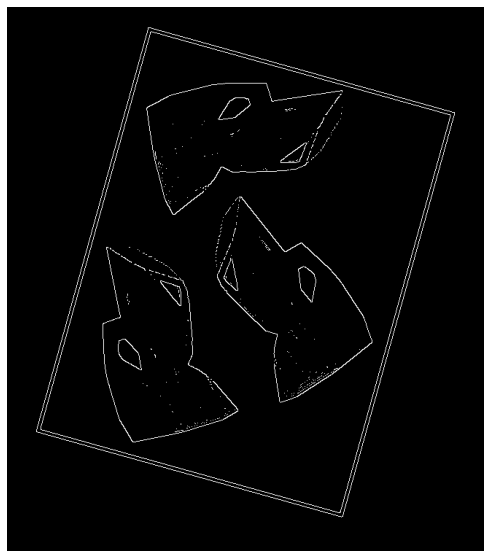

In [265]:
ex = 100 #@param 
ey = 100 #@param
image_edge = iacv.edge(image, e_range = [ex, ey])
iacv.imshow(image_edge)

# check whether gray scale
print(f"Shape of the image: {image_edge.shape}")

Now we can find the contours of this image. We will do so using the `cv2.findContours` functions which is a well-known and quite robust contour finding method ([original 1985 paper](https://www.sciencedirect.com/science/article/abs/pii/0734189X85900167)). As with any function, it has many tweakable parameters. 

The first is the **image** it works on; the second the **retrieval mode** ; and the third the utilized **algorithm**. We are only interested in the outer contour, so we choose `cv2.RETR_EXTERNAL`, and use an approximate function `cv2.CHAIN_APPROX_TC89_L1`. Feel free to try out other methods, which can be found in the function's [documentation](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0).

In [266]:
cnts, hierarchy = cv2.findContours(image_edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)

print(f"The number of detected contours: {len(cnts)}")
print(f"First contour: {cnts[0].squeeze()}")
print(f"Length of first contour, ie number of points: {len(cnts[0])}")

The number of detected contours: 1
First contour: [[193  28]
 [193  31]
 [192  35]
 ...
 [204  30]
 [200  29]
 [197  28]]
Length of first contour, ie number of points: 547


The algorithm nicely found one contour, but ... the amount of coordinates is huge. It doesn't know what shape the reference frame is. We do, namely a square. The OpenCV library has two functions that can find the closest rectangle to a set of points: `cv2.minAreaRect()` and `cv2.boxPoints`. Let's implement it.

In [267]:
cnt = cnts[0]
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
print(box)

[[ 38.82843 582.58936]
 [193.28992  26.95705]
 [614.1806  143.96143]
 [459.71912 699.59375]]


We will use the [`shapely`](https://shapely.readthedocs.io/en/stable/manual.html) library to convert contours of any form to closed-loop polygons. We can simply call `shapely.geometry.Polygon` and only input the coordinates of every contour to generate what we want. (`shapely` is a proper geometry library in Python in which handling geometric object such as points, lines, polygons, and more complex ones.)

In [268]:
from shapely.geometry import Polygon

polygon = Polygon(box)
print(polygon)

POLYGON ((38.82843017578125 582.58935546875, 193.2899169921875 26.957050323486328, 614.1806030273438 143.96142578125, 459.7191162109375 699.59375, 38.82843017578125 582.58935546875))


Let's plot the polygon on top of the original image.

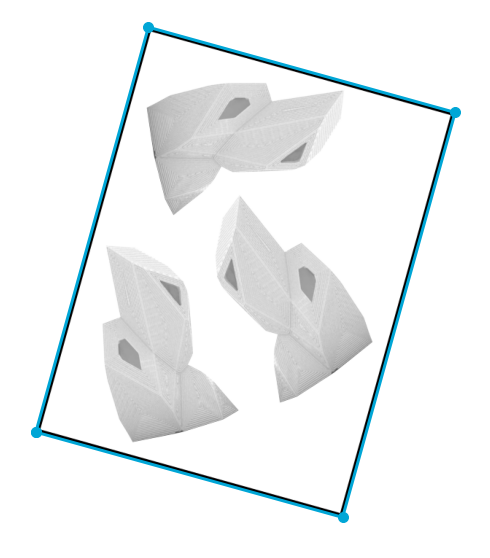

In [269]:
import matplotlib.pyplot as plt

# to make sure delft is well promoted ;)
delft_color = "#00A6D6"

# fig settings
fs = 10
fig, ax = plt.subplots(1,1,figsize=(fs, fs))
ax.axis('off')

# plot image; plot polygon 
# (you can simply plot them by writing two lines!)
ax.imshow(image)
# set color, marker type, markersize, and linewidth to your preference!
iacv.plot_polygon(polygon, ax, color=delft_color, marker='o', markersize=10, linewidth=3)

It indeed correctly found the frame! Let's warp it now. This function can be found the `iacv` library: `iacv.warp`. Make sure to input the contour and not the polygon!

Shape of the warped image:	(576, 436, 3)
Shape of the original image:	(746, 654, 3)


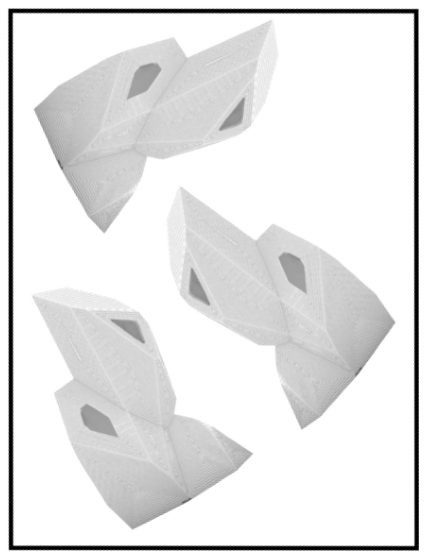

In [270]:
image_warp = iacv.warp(image, cnt)
iacv.imshow(image_warp)
print(f"Shape of the warped image:\t{image_warp.shape}") 
print(f"Shape of the original image:\t{image.shape}") 

The image is indeed nicely warped based on the reference frame. (Note also that the dimensions are correct; the warp did not stretch or strangely modified the content.) 

---

Let's get rid of the black edges: `iacv.border2color`.

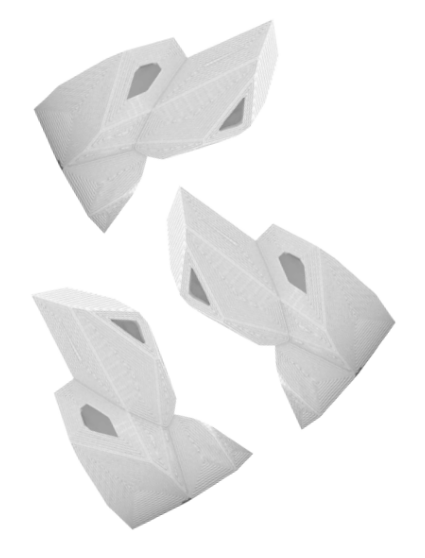

In [271]:
image_warp = iacv.border2color(image_warp)
iacv.imshow(image_warp)

*What happens when you make the offset argument too small? And what happens when you set it too large?*

---

Suppose we know the width of the reference frame, say 100 cm. We can compute the amount of pixels that occupies 1 cm, or in other word the **pixel per centimeter** (ppcm). We can simply compute it by `iacv.pixpermetric`. Make sure to put the correct metric argument ('cm' in this case).

In [272]:
print(f"Shape of the warped image: {image_warp.shape}") 
ppcm = iacv.pixpermetric(image_warp, 100, metric='cm', show=True)

Shape of the warped image: (576, 436, 3)
Pixels per cm in X and Y = 4.36


This is indeed correct given the shape of the image. (*Why?*)

## Detect and allocate component of interest

Let's try to use a similar strategy to find a particular component of interest. Let's see what happens if we use the exact same strategy as before (first: edge, second: contour finding).

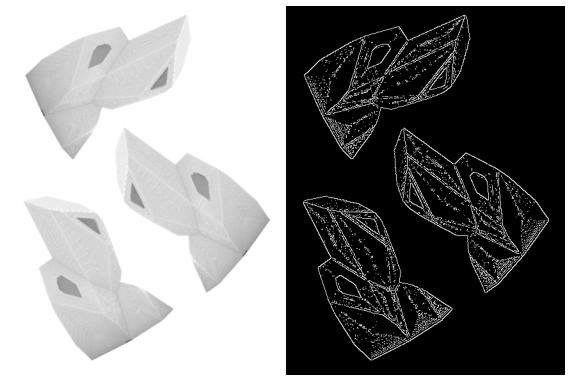

In [273]:
import numpy as np

ex = 35 #@param 
ey = ex #@param
image_warp_edge = iacv.edge(image_warp, e_range=[ex, ey])
image_stack = iacv.concat_images_horizontally([image_warp, image_warp_edge])
iacv.imshow(image_stack)

In [274]:
cnts, hierarchy = cv2.findContours(image_warp_edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1 )
print(f"The number of detected contours: {len(cnts)}")

The number of detected contours: 1919


This seems like to many contours... What happened? Let's plot it. (Again: using polygons.)

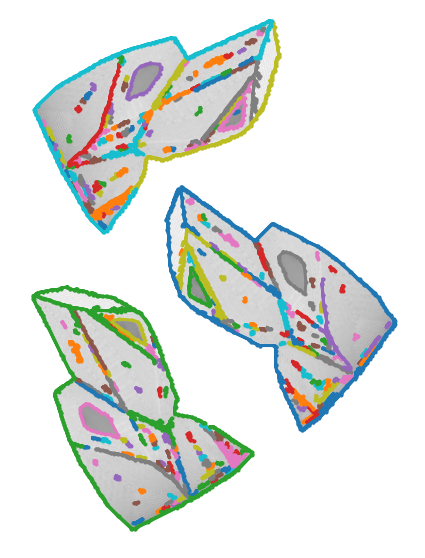

In [276]:
polygons = iacv.contours2polygons(cnts)

# fig settings
fs = 10
fig, ax = plt.subplots(1,1,figsize=(fs, fs))
ax.axis('off')

ax.imshow(image_warp)
for pol in polygons:
  iacv.plot_polygon(pol, ax, marker='o', markersize=3, linewidth=3)

Looks cool, but not what we would like to see. Let's get rid of polygons with an area smaller than 200 cm2. (*Why 200?*)

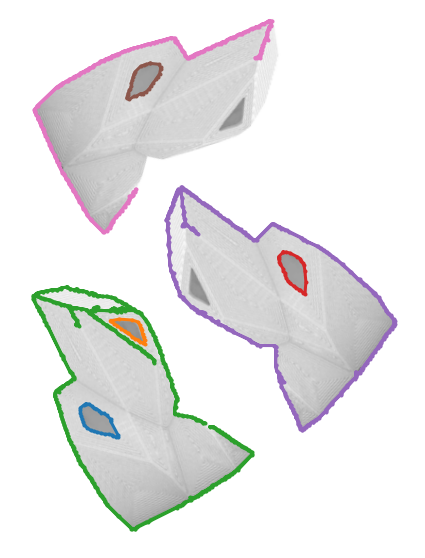

In [277]:
# fig settings
fs = 10
fig, ax = plt.subplots(1,1,figsize=(fs, fs))
ax.axis('off')

a_min = 200

ax.imshow(image_warp)
# set color, marker type, markersize, and linewidth to your preference!
for pol in polygons:
  if pol.area < a_min: continue
  iacv.plot_polygon(pol, ax, marker='o', markersize=3, linewidth=3)

Clearly some interesting confetti; but not what we hoped for. (Note: the holes it sort of already found correctly! 

--- 

Maybe because of the not even structure that there are too many edges for the contour finding algorithm. Let's blur the image a little.

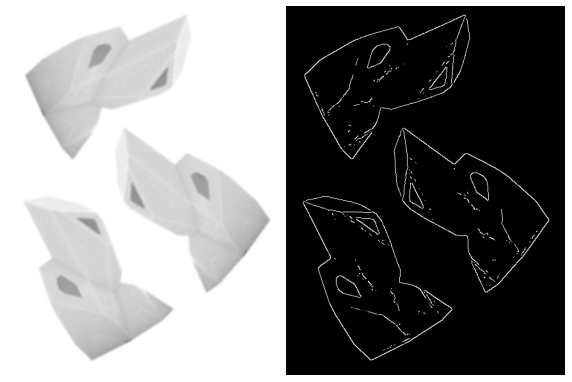

In [278]:
ksize = 7 #@param
image_warp_blur = iacv.blur(image_warp, ksize=ksize)

ex = 25  #@param 
ey = 25  #@param
image_warp_edge = iacv.edge(image_warp_blur, e_range=[ex, ey])

image_stack = iacv.concat_images_horizontally([image_warp_blur, image_warp_edge])
iacv.imshow(image_stack)

The number of detected contours: 174


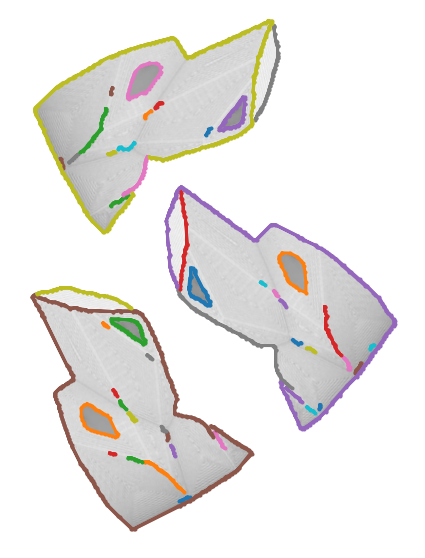

In [279]:
cnts, hierarchy = cv2.findContours(image_warp_edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1 )
print(f"The number of detected contours: {len(cnts)}")

polygons = iacv.contours2polygons(cnts)

# fig settings
fs = 10
fig, ax = plt.subplots(1,1,figsize=(fs, fs))
ax.axis('off')

# plot image; plot polygon 
# (you can simply plot them by writing two lines!)
ax.imshow(image_warp)
# set color, marker type, markersize, and linewidth to your preference!
for pol in polygons:
  iacv.plot_polygon(pol, ax, marker='o', markersize=3, linewidth=3)

Looks better, but still not what we want.

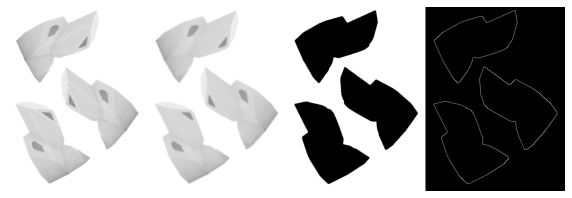

In [280]:
image = image_warp
image = iacv.blur(image, ksize=7)
image = cv2.pyrMeanShiftFiltering(image, 10, 10)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

thresh = 245 #@param
image_thresh = np.where(image_gray < thresh, 0.0, 255.0)
image_thresh = np.uint8(image_thresh)

ex = 20  #@param 
ey = 20  #@param
image_warp_edge = iacv.edge(image_thresh, e_range=[ex, ey])

image_stack = iacv.concat_images_horizontally([image_warp,
                                             image_gray, 
                                             image_thresh,
                                             image_warp_edge])
iacv.imshow(image_stack)

The number of detected contours: 3


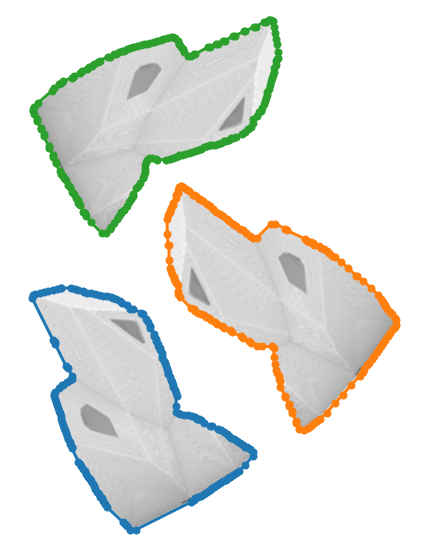

In [281]:
cnts, hierarchy = cv2.findContours(image_warp_edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1 )
print(f"The number of detected contours: {len(cnts)}")
polygons = iacv.contours2polygons(cnts)

# fig settings
fs = 10
fig, ax = plt.subplots(1,1,figsize=(fs, fs))
ax.axis('off')

ax.imshow(image_warp)
for pol in polygons:
  iacv.plot_polygon(pol, ax, marker='o', markersize=7, linewidth=3)

The amount of points per polygon is huge; let's simplify with the following function:

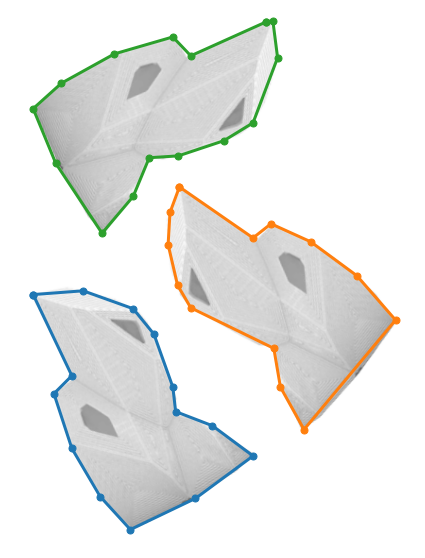

In [283]:
import numpy as np

polygons_simplified = iacv.simplify_polygons(polygons)

# fig settings
fs = 10
fig, ax = plt.subplots(1,1,figsize=(fs, fs))
ax.axis('off')

ax.imshow(image_warp)
for pol in polygons_simplified:
  iacv.plot_polygon(pol, ax, marker='o', markersize=7, linewidth=3)

This looks good. Let's focus on one of the components, by masking the image based on one of the polygons. We need another package: `rasterio`. `rasterio.features.rasterize` can rasterize a geometric object.

In [284]:
'rasterio' in sys.modules

True

In [ ]:
# !pip install rasterio

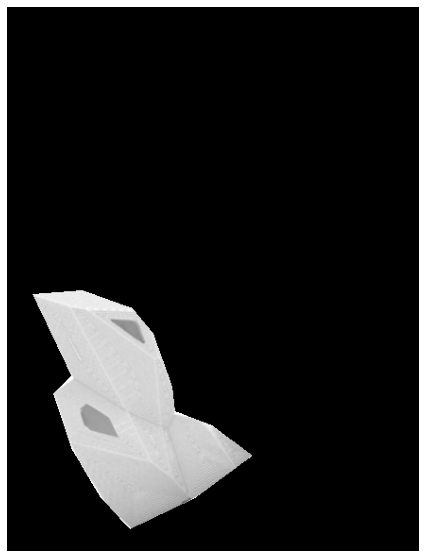

In [285]:
from rasterio import features

mask = features.rasterize([polygons_simplified[0]], out_shape=image_warp.shape[:2])
img_warp_c1 = image_warp * np.stack([mask]*3, axis=2)
iacv.imshow(img_warp_c1)

## Find holes

The only thing that remains is to guide robotic hand to a point where it can easily grab the component. As you know, the robotic arm can best grab the component through one of it's holes. We will find the holes and largest edge (including angle) again with the same contour finding technique.

The number of detected contours: 195


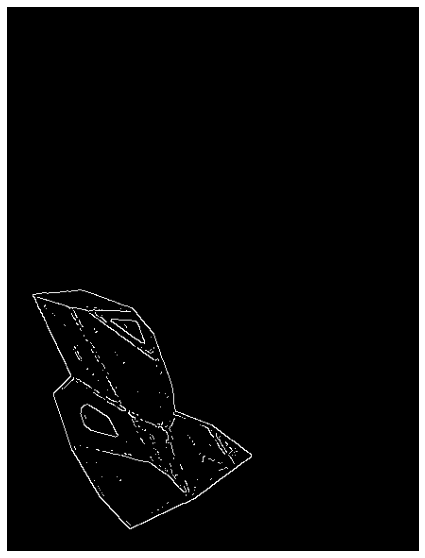

In [286]:
image = img_warp_c1
image = iacv.blur(image, ksize=5)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# edge
ex = 25 #@param
ey = ex
image = iacv.edge(image, e_range = [ex, ey])
iacv.imshow(image)

# find contours
cnts, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_L1 )
print(f"The number of detected contours: {len(cnts)}")

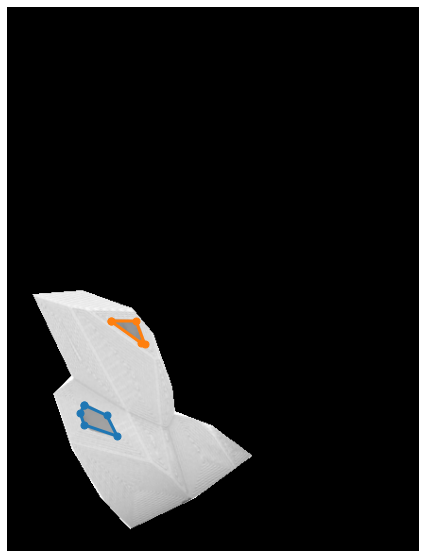

In [287]:
a_min = 250 #@param
a_max = 800 #@param

polygons = iacv.get_hole_polygons_from_contours(cnts, a_min, a_max)

# fig settings
fs = 10
fig, ax = plt.subplots(1,1,figsize=(fs, fs))
ax.axis('off')

# plot image; plot polygon 
# (you can simply plot them by writing two lines!)
ax.imshow(img_warp_c1)
# set color, marker type, markersize, and linewidth to your preference!
for pol in polygons:
  iacv.plot_polygon(pol, ax, marker='o', markersize=7, linewidth=3)

We can now determine the center points of one of the two polygons that describes the hole. More precisely, we will guide robotic arm towards the longest edge; give the middle point of that edge; and it relative (to the frame) orientation.

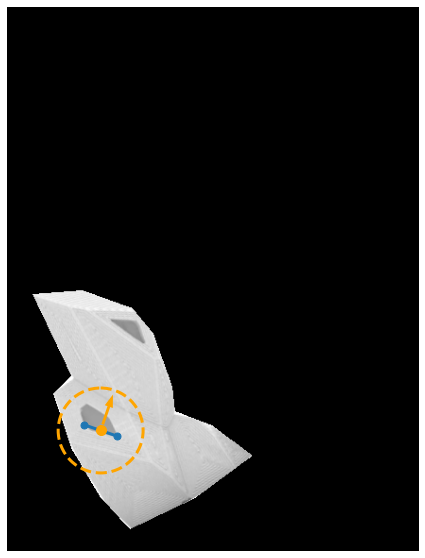

In [289]:
from shapely.geometry import LineString, Point
import math

pol = polygons[0]

# fig settings
fs = 10
fig, ax = plt.subplots(1,1,figsize=(fs, fs))
ax.axis('off')

centroid, angle = iacv.plot_robot_grab(img_warp_c1, pol, ax)
